С помощью pytorch подгрузим обученную сеть и протестируем ее на нескольких рандомных картинках


In [1]:
import torch
import torchvision as tv
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from xml.etree import ElementTree
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import gdown
import matplotlib.patches as mpatch

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Для работы был выбран датасет с фруктами

*https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection*

In [3]:
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM', output='34662_46346_bundle_archive.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM
To: /content/34662_46346_bundle_archive.zip
29.7MB [00:00, 103MB/s] 


'34662_46346_bundle_archive.zip'

In [4]:
! unzip -q /content/34662_46346_bundle_archive.zip

План!

1) Создать классы (наследуется от datasets)

2) Список картинок - переводим в тензор

3) Парсинг xml - получаем лейбл и координаты box'a 

4) Для передачи в loader преобразуем выход в x,y 

x - list тензоров, каждый тензор - картинка shape [Chanels, Hight, Wight] отнормированные от 0 до 1. Можно не ресайзить, но можно и ресайзить

y - list словарей

{Ключ 'boxes'} Cловарь содержит в себе boxes формы FloatTensor[N,4], где 4 - это координаты [x1, y1, x2, y2] - значения x (0,W), а значение y (0,H)

{Ключ 'labels'} Здесь только номер класса



In [5]:
labels_code = ['__background__','apple', 'orange', 'banana']

class Fruit_Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode):
        self.root_dir = root_dir
        self.mode = mode

        p = Path(self.root_dir)
        if mode == 'train':
            p_train = p / 'train_zip' / 'train'
            self.img_jpg = sorted(list(p_train.glob('*.jpg')))
            self.img_xml = sorted(list(p_train.glob('*.xml')))

        if mode == 'test':
            p_train = p / 'test_zip' / 'test'
            self.img_jpg = sorted(list(p_train.glob('*.jpg')))
            self.img_xml = sorted(list(p_train.glob('*.xml')))

    def __len__(self):
        return len(self.img_jpg)

    def __getitem__(self, index):
        image = self.img_jpg[index] # one sample
        label = self.img_xml[index]

        img = (Image.open(image)).convert("RGB")
        img_tensor = tv.transforms.ToTensor()(img)  # X

        tree = ElementTree.parse(label)
        root = tree.getroot()
        

        labels_code = ['__background__','apple', 'orange', 'banana']
        label_iter = []
        coordinate = []
        labels = []  # Y
        for obj in root.iter('object'):
            coord_iter = []
            for child in obj:
                if child.tag == 'name':
                    label_iter.append(int(labels_code.index(child.text)))
                if child.tag == 'bndbox':
                    for coord in child:
                      coord_iter.append(float(coord.text))
                    coordinate.append(coord_iter)
        coord_tensor = torch.FloatTensor(coordinate)
        label_tensor = torch.LongTensor(label_iter)
        dict_iter = {'boxes': coord_tensor, 'labels': label_tensor} # Y
        labels.append(dict_iter)
        return img_tensor, dict_iter
    

In [6]:
train_set = Fruit_Dataset(root_dir='/content', mode='train')
test_set = Fruit_Dataset(root_dir='/content', mode='test')

In [7]:
def my_collate(batch):
    data = [item[0].to(device) for item in batch]
    target = [item[1] for item in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return data, target

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=my_collate)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=my_collate)

In [9]:
def parse_xml(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    
    labels_code = ['apple', 'orange', 'banana']
    label_iter = []
    coordinate = []
    for obj in root.iter('object'):
        coord_iter = []
        for child in obj:
            if child.tag == 'name':
                label_iter.append(labels_code.index(child.text))
            if child.tag == 'bndbox':
                for coord in child:
                  coord_iter.append(int(coord.text))
                coordinate.append(coord_iter)
    return label_iter, coordinate # returns 2 lists
    


In [10]:
def let_s_paint(folder, number_pictures = 3):
    p_train = Path(folder) / 'train_zip' / 'train'
    images = sorted(list(p_train.glob('*.jpg')))
    boxes = sorted(list(p_train.glob('*.xml')))

    image_index = [np.random.randint(0, len(images)) for i in range(number_pictures)]
    
    # draw pictures from train dataset
    fig = plt.figure(figsize=(15,10))
    for i in range(number_pictures):
        add = fig.add_subplot(1, number_pictures, i + 1)
        img = plt.imread(images[image_index[i]])
        plt.imshow(img)

    fig = plt.figure(figsize=(10,10))

    # draw pictures from train dataset with boxes
    for i in range(number_pictures):
        lab, box_border = parse_xml(boxes[image_index[i]])

        add = fig.add_subplot(1, number_pictures, i + 1)
        img = plt.imread(images[image_index[i]])

        for j in range(len(box_border)):
            rectangle = mpatch.Rectangle((box_border[j][0], box_border[j][1]),
                          box_border[j][2] - box_border[j][0],
                          box_border[j][3] - box_border[j][1],
                          fill=False, linewidth=2, color = 'green')
            plt.text(box_border[j][0], box_border[j][1], labels_code[lab[j]+1],
                     fontsize=12, bbox=dict(facecolor='yellow', alpha=0.4),horizontalalignment='left', verticalalignment='bottom')
            add.add_patch(rectangle)
            plt.imshow(img)
    return 

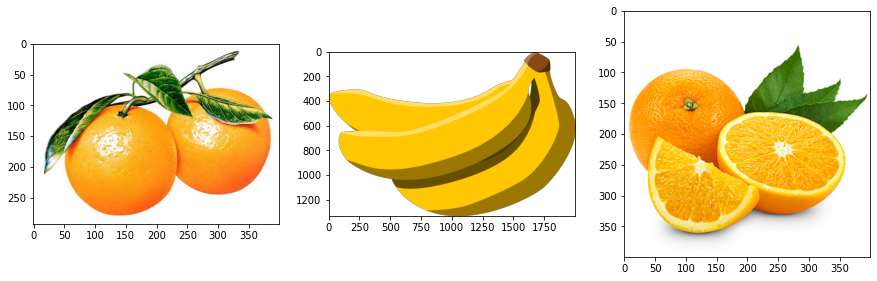

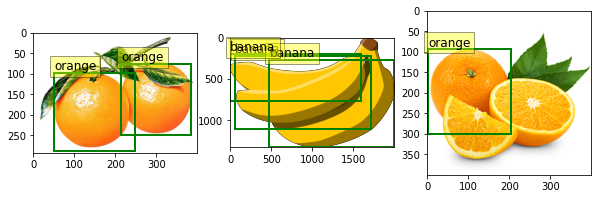

In [11]:
let_s_paint('/content')

1. Пишем TRain 
2. Пишем Test
3. Изменяем модель
4. Тренируем модель (только loss)
5. Тестируем модель (здесь же метрики)

In [12]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [13]:
model.to(device);

In [14]:
optim = torch.optim.Adam(model.parameters())

In [15]:
#Train
def train_set(model, optimizer, dataset):
    model.train()
    mega_loss = 0
    for imgs, labs in dataset:
        dict_predict = model(imgs, labs)
        sum_loss = sum(loss for loss in dict_predict.values())
        mega_loss += sum_loss.item()
        optimizer.zero_grad()
        sum_loss.backward()
        optimizer.step()
    print(f'loss for epoch {mega_loss}')
    return mega_loss


In [16]:
num_epochs = 15
for epoch in range(num_epochs):
    print(f'epoch {epoch}')
    train_set(model, optim, train_loader)

epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


loss for epoch 22.41533949226141
epoch 1
loss for epoch 9.937248475849628
epoch 2
loss for epoch 8.99894542619586
epoch 3
loss for epoch 8.651900451630354
epoch 4
loss for epoch 8.290955506265163
epoch 5
loss for epoch 8.129777017980814
epoch 6
loss for epoch 7.872138973325491
epoch 7
loss for epoch 7.897036701440811
epoch 8
loss for epoch 7.582617912441492
epoch 9
loss for epoch 7.6969202272593975
epoch 10
loss for epoch 7.285422638058662
epoch 11
loss for epoch 7.384252768009901
epoch 12
loss for epoch 7.047752790153027
epoch 13
loss for epoch 6.982455626130104
epoch 14
loss for epoch 6.924204979091883


In [17]:
img_apple = requests.get('https://avatars.mds.yandex.net/get-zen_doc/175411/pub_5c861c586508fd00b373ce0c_5c862ed859b73700b00c8f1a/scale_1200').content

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


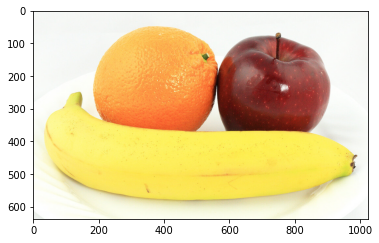

In [18]:
pil_img_apple = Image.open(BytesIO(img_apple))
plt.imshow(pil_img_apple)
model.eval()
img_train = tv.transforms.ToTensor()(pil_img_apple).unsqueeze(0)
img_train = img_train.to(device)
predict = model(img_train)

In [19]:
def paint_it(image_pill, dict_box):
    labels_code = ['0','apple', 'orange', 'banana']
    dict_box = [{k: v.cpu() for k, v in t.items()} for t in dict_box]
    img_np = np.array(image_pill)
    dict_box_np =  dict_box[0]['boxes'][dict_box[0]['scores'] > 0.45].detach().numpy()
    dict_box_lb = dict_box[0]['labels'][dict_box[0]['scores'] > 0.45].detach().numpy()
    for i in range(len(dict_box_np)):
        img_rec = cv2.rectangle(
            img_np,
            (dict_box_np[i][0], dict_box_np[i][1]),
            (dict_box_np[i][2], dict_box_np[i][3]),
            255, 3
        )

        cv2.putText(img_np, str(labels_code[dict_box_lb[i]]),\
                    (int(dict_box_np[i][0]), int(dict_box_np[i][1])), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,255,255), 2)
    plt.figure(figsize=(10,10))
    return plt.imshow(img_rec)

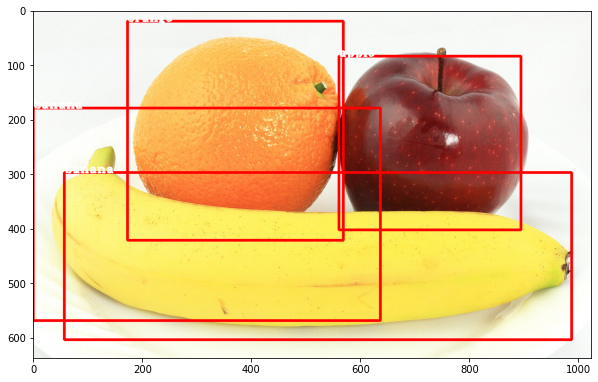

In [20]:
paint_it(pil_img_apple, predict)

In [21]:
def iou_metrics(y_true: list, y_preds: list):
    #  model(x) --> y_preds = [{'boxes':'...', 'labels':'...', 'scores':'...'}]

    #  intersection
    x1 = max(y_true[0], y_preds[0])
    y1 = max(y_true[1], y_preds[1])
    x2 = min(y_true[2], y_preds[2])
    y2 = min(y_true[3], y_preds[3])

    intersect_sq = abs(x1 - x2) * abs(y1 - y2)

    #  union
    #  box_1 - true
    box_1_sq = (y_true[2] - y_true[0]) * (y_true[3] - y_true[1])
    #  box_2 - pred
    box_2_sq = (y_preds[2] - y_preds[0]) * (y_preds[3] - y_preds[1])

    union_sq = box_1_sq + box_2_sq - intersect_sq

    iou = intersect_sq/(union_sq + 0.00001)
    return iou

In [22]:
# Validation
def validation(model, val_set, pred_score = 0.3):
    model.eval()
    with torch.no_grad():
        for img, boxes in val_set:
            #img = img.unsqueeze(0)

            y_true = boxes
            y_preds = model(img)

            real_box = y_true[0]['boxes']
            real_class = y_true[0]['labels']
            pred_box = y_preds[0]['boxes'][y_preds[0]['scores'] > pred_score]
            pred_class = y_preds[0]['labels'][y_preds[0]['scores'] > pred_score]

            pred_class_set = torch.unique(pred_class)
            break
        

    return y_preds, y_true, pred_class_set

In [23]:
y_preds, y_true, pred_class_set = validation(model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Необходимо осортировать по лейблам.
В зависимости от лейбла который РАЗМЕЧЕН мы определяем:

    если нет такого класса - это FN
    если такой класс есть, смотрим правильно ли он размечен

Для этого смотрим на размеченный бокс и считаем iou для него и каждого бокса из заданного класса, размеченного сетью. Получаем матрицу, в которой

    если Iou > 1 - пересечения нет и может присваиваться 0
    если Iou >> 1 - также
    если Iou = 0 - это сулчай невозможный вообще

Чем больше IoU для данного размеченного бокса и бокса размеченного сетью, тем лучше. Максимальный iou берем как ответ.

->Получаем матрицу вероятностей
Просим компуктер максимальным вероятностям в строчке присвоить 1 (True), а всем остальным 0
Смотрим, чтобы на 1 нарисованный BB приходился 1 размеченный сетью

->Считаем сколько получилось лишних BB - они FP
Если BB размеченному не соответствует ничего, то записываем его как FN

->Строим финальную табличку вывод, где записываем
1) Класс рассматриваемых BB
2) Сколько BB было предсказано с вероятностью до 0.5
3) Сколько BB было предсказано с вероятностью более 0.5
4) Сколько FN
5) Сколько FP
6) Сколько TP
7) По каждому BB написать iou

Это делаем для каждого класса
Выводим метрики для каждого класса precision и recall
Общий precision и recall

In [24]:
y_true

[{'boxes': tensor([[ 71.,  60., 175., 164.],
          [ 12.,  22., 105., 111.],
          [134.,  23., 243., 115.],
          [107., 126., 216., 229.],
          [207., 138., 298., 229.]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0')}]

In [29]:
under_half_preds = y_preds[0]['labels'][y_preds[0]['scores'] < 0.5].shape
upper_half_preds = y_preds[0]['labels'][y_preds[0]['scores'] > 0.5].shape
print(f'{under_half_preds[0]} боксов с вероятностью менее 0.5, {upper_half_preds[0]} боксов с вероятностью более 0.5') # количество предсказанных BB с вероятностью менее 0.5 и более 0.5

16 боксов с вероятностью менее 0.5, 8 боксов с вероятностью более 0.5


In [32]:
uniq_labels_true = torch.unique(y_true[0]['labels'])
uniq_labels_preds = torch.unique(y_preds[0]['labels'][y_preds[0]['scores'] > 0.5])
print(f'предсказанные уникальные классы: {uniq_labels_preds.cpu().numpy()}, размеченные уникальные классы: {uniq_labels_true.cpu().numpy()}')  # сколько уникальных лейблов в предсказанных и правильных

предсказанные уникальные классы: [1], размеченные уникальные классы: [1]


In [ ]:
FP = 0 #  переменные для будущих метрик
FN = 0
TP = 0

In [33]:
#  Проверка на обученность
for i in uniq_labels_true:
    if i not in uniq_labels_preds:
        print(f'Класс {i} не был определен')
    else:
        print(f'Класс {i} был определен')

Класс 1 был определен


In [34]:
#  Необходимо сравнить, чтобы уточнить количество неправильно определенных классов
for i in uniq_labels_true:
    #  Если они не равны, отбрасываем боксы всех классов, которые встречаются и там и там, и считаем сколько неверных классов было отмечено!
    #  Это будут боксы FP
    #  После этого нужно оставить только классы, которые есть в разметке
    
    box_true = y_true[0]['boxes'][y_true[0]['labels'] == i]
    box_pred = y_preds[0]['boxes'][(y_preds[0]['labels'] == i) & (y_preds[0]['scores'] > 0.4)]
    iou_matrix = []

    for k in range(len(box_true)):
        now_true_box = box_true[k]
        #  сравним со всеми предсказанными боксами
        iou_list = []
        for j in range(len(box_pred)):
            metric = iou_metrics(now_true_box, box_pred[j])
            iou_list.append(metric.item())
        iou_matrix.append(iou_list)
    

matr = torch.FloatTensor(iou_matrix)


tensor([[ 73.1257,  63.3201, 169.7839, 173.6966],
        [105.9637, 131.0859, 210.9599, 229.0000],
        [212.1294, 145.9870, 297.3921, 229.0000],
        [ 82.3339,   0.9453, 131.7023,  45.0100],
        [  8.4516,  24.0006,  87.1025,  93.5854],
        [149.4825,  30.5196, 233.2577, 109.1939],
        [147.9883,  60.0226, 227.5130, 126.1624],
        [ 96.4852,  92.1918, 213.1176, 203.4733]], device='cuda:0')


In [35]:
print(matr)

tensor([[8.2799e-01, 1.2071e-01, 3.8828e-02, 6.0404e-02, 3.4341e-02, 7.7720e-02,
         1.2503e-01, 3.1051e-01],
        [8.7212e-02, 1.0441e-03, 3.2293e-01, 5.2518e-02, 6.1310e-01, 3.0784e-01,
         1.9316e-01, 7.5914e-03],
        [9.8120e-02, 6.4915e-02, 5.9234e-02, 4.1613e-03, 2.6667e-01, 6.5726e-01,
         4.0053e-01, 8.5109e-02],
        [1.5843e-01, 8.9854e-01, 1.7867e-02, 1.7547e-01, 4.0173e-02, 6.6940e-02,
         6.7023e-04, 5.1432e-01],
        [7.5391e-02, 1.9798e-02, 8.5472e-01, 2.0269e+00, 6.3179e-01, 5.3585e-02,
         1.8260e-02, 1.9202e-02]])


In [47]:
x = (matr < 1) & (matr > 0.5)
x

tensor([[ True, False, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False,  True, False, False, False, False, False,  True],
        [False, False,  True, False,  True, False, False, False]])

In [49]:
matr_with_x = matr * x

In [52]:
matr_with_x

tensor([[0.8280, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6131, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6573, 0.0000, 0.0000],
        [0.0000, 0.8985, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5143],
        [0.0000, 0.0000, 0.8547, 0.0000, 0.6318, 0.0000, 0.0000, 0.0000]])

In [58]:
#  Вывести максимальный элемент в строке
y = matr_with_x.max(1, keepdim=True)[0]

In [60]:
matr_x_with_y = (matr_with_x == y)

In [61]:
final_matr = matr_with_x * matr_x_with_y

In [62]:
final_matr

tensor([[0.8280, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6131, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6573, 0.0000, 0.0000],
        [0.0000, 0.8985, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8547, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [ ]:
# Теперь считаем tp и все такое